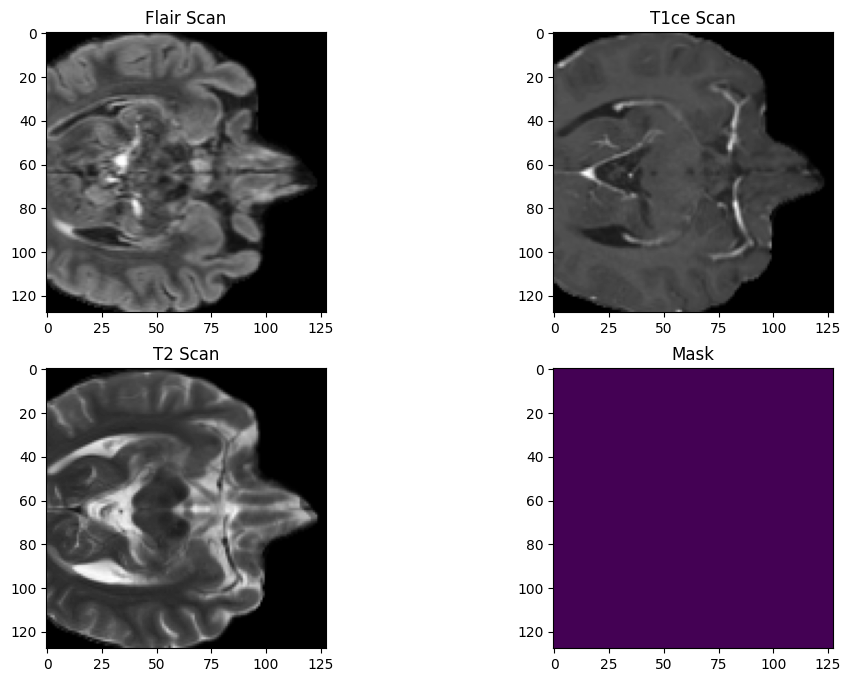

In [7]:
import os
import numpy as np

def load_img(img_dir, img_list):
    images = []
    for i, image_name in enumerate(img_list):
        if image_name.split('.')[1] == 'npy':
            image = np.load(img_dir + image_name)
            # Seleccionar solo los primeros tres canales
            #image = image[:, :, :, :3]
            images.append(image)
            #print("Shape of loaded image:", np.shape(image))  # Imprimir la forma de la imagen cargada
    images = np.array(images)
    return images


def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
  L = len(img_list)
  # keras needs the generator infinite, so use while True
  while True:
    batch_start = 0
    batch_end = batch_size

    while batch_start < L:
      limit = min(batch_end, L)
      X = load_img(img_dir, img_list[batch_start:limit])
      Y = load_img(mask_dir, mask_list[batch_start:limit])

      yield(X, Y) # a tuple with two numpy arrays with batch_size samples

      batch_start += batch_size
      batch_end += batch_size


# Test the generator
TRAIN_DATASET_PATH = "input_data_128/train/"
train_img_dir = TRAIN_DATASET_PATH + 'images/'
train_mask_dir = TRAIN_DATASET_PATH + 'masks/'

train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

# Verify generator - In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0, img.shape[0]-1)

test_img = img[img_num]
test_mask = msk[img_num]
test_mask = np.argmax(test_mask, axis=3)

n_slice = random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12,8))

plt.subplot(221)
plt.imshow(test_img[:, :, n_slice, 0], cmap='gray')
plt.title('Flair Scan')

plt.subplot(222)
plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')
plt.title('T1ce Scan')

plt.subplot(223)
plt.imshow(test_img[:, :, n_slice, 2], cmap='gray')
plt.title('T2 Scan')

plt.subplot(224)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')

plt.show()

In [8]:
# Obtener el primer lote de imágenes y máscaras
img, _ = next(train_img_datagen)

# Imprimir las dimensiones de las imágenes en el primer lote
print("Dimensiones de las imágenes en el primer lote:", img.shape)



Dimensiones de las imágenes en el primer lote: (2, 128, 128, 128, 3)


In [9]:
DATASET_PATH = 'input_data_128/'
train_img_dir = DATASET_PATH + 'train/images/'
train_mask_dir = DATASET_PATH + 'train/masks/'

val_img_dir = DATASET_PATH + 'val/images/'
val_mask_dir = DATASET_PATH + 'val/masks/'


train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

batch_size = 2
train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)
val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)


In [12]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [16]:
kernel_initializer = 'he_uniform'


In [17]:
def UNet(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))

  # Downsampling
  c1 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(inputs)
  c1 = Dropout(0.1)(c1)
  c1 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
  p1 = MaxPooling3D((2, 2, 2))(c1)

  c2 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
  p2 = MaxPooling3D((2, 2, 2))(c2)

  c3 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
  p3 = MaxPooling3D((2, 2, 2))(c3)

  c4 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
  p4 = MaxPooling3D((2, 2, 2))(c4)

  c5 = Conv3D(filters = 256, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv3D(filters = 256, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

  # Upsampling part
  u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

  u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

  u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

  u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1])
  c9 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

  outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  model.summary()

  return model

In [23]:
from tensorflow.python.keras.metrics import MeanIoU

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model = UNet(IMG_HEIGHT = 128,
              IMG_WIDTH = 128,
              IMG_DEPTH = 128,
              IMG_CHANNELS = 3,
              num_classes = 5)

optim = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy', MeanIoU(num_classes=5), dice_coef, precision, sensitivity, specificity])


print(model.summary)

print(model.input_shape)
print(model.output_shape)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d_95 (Conv3D)              (None, 128, 128, 128 1312        input_8[0][0]                    
__________________________________________________________________________________________________
dropout_45 (Dropout)            (None, 128, 128, 128 0           conv3d_95[0][0]                  
__________________________________________________________________________________________________
conv3d_96 (Conv3D)              (None, 128, 128, 128 6928        dropout_45[0][0]                 
____________________________________________________________________________________________

In [24]:
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TerminateOnNaN

checkpoint_path = 'ckeck.keras'
log_path = 'track.log'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1,
                      monitor='val_loss',
                      patience=4,
                      min_lr=0.0001,
                      verbose=1,
                      mode='min'),
    ModelCheckpoint(checkpoint_path,
                    monitor='val_loss',
                    mode='min',
                    verbose=0,
                    save_best_only=True),
    CSVLogger(log_path, separator=',', append=True),
    TerminateOnNaN()
]

history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=100,
                    verbose=1,
                    validation_data=val_img_datagen,
                    validation_steps=val_steps_per_epoch
                    )


history_callback = np.save('history_callback.npy', history.history)

Epoch 1/100


ResourceExhaustedError:  OOM when allocating tensor with shape[2,16,128,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/model_5/conv3d_112/Conv3D/Conv3DBackpropInputV2 (defined at \AppData\Local\Temp\ipykernel_10644\1839071495.py:24) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_7364]

Function call stack:
train_function
